*Ce billet a été écrit à l'aide d'un notebook Jupyter. Son contenu est sous licence BSD. Une vue statique de ce notebook peut être consultée et téléchargée ici : [20170625_Legislatives.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170625_Legislatives.ipynb).*

Dans ce billet, écrit après les résultats du deuxième tour des élections législatives 2017, nous allons faire les choses suivantes. Tout d'abord, nous allons produire quelques graphiques relatifs aux résultats du deuxième tour, dans une approche descriptive. Dans un deuxième temps, nous évaluerons plusieurs modèles de report des voix pour voir si l'utilisation de modèles de comportement apporte une compréhension des résultats réels ou pas.

# Téléchargement des données depuis le site du ministère de l'intérieur 

Pour commencer notre étude, nous allons nous appuyer sur les routines du [billet précédent](http://flothesof.github.io/resultats-legislatives-2017-premier-tour.html). 

In [1]:
# import des packages 
from bs4 import BeautifulSoup
import requests
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
from collections import OrderedDict
from scipy import stats
import numpy as np

Tout d'abord, nous extrayons les liens vers les circonscriptions par département.

In [2]:
url = 'http://elections.interieur.gouv.fr/legislatives-2017/'
soup = BeautifulSoup(requests.get(url).text, 'html.parser')
links = [url + tag.attrs['href'][2:] for tag in soup.find_all('a', class_='Style6')]
links += list(set([url + tag.attrs['href'] for tag in soup.find_all('area') if 'href' in tag.attrs]))

In [3]:
len(links)

107

A partir de ces liens, nous allons chercher les liens vers les pages individuelles des circonscriptions.

In [4]:
from functools import lru_cache

In [5]:
@lru_cache(maxsize=None)
def fetch_page(url):
    "Fetches url for webpage."
    r = requests.get(url)
    return r

In [6]:
circo_links = []
for link in links:
    soup = BeautifulSoup(fetch_page(link).text, 'html.parser')
    circo_links += [url + tag.attrs['href'][3:] for tag in soup.find_all('a') if 'circonscription' in tag.text.lower()]

In [7]:
len(circo_links)

577

On peut maintenant extraire les informations à partir de chaque circonscription. On trouve des tables pour le premier ainsi que pour le deuxième tour sur chaque page de circonscription. Sauf pour les circonscriptions où il n'y avait pas de deuxième tour. Ceci complique légèrement les extractions.

In [8]:
link = circo_links[1]
soup = BeautifulSoup(fetch_page(link).text, 'html.parser')

In [9]:
link

'http://elections.interieur.gouv.fr/legislatives-2017/066/06601.html'

In [10]:
len(soup.find_all('h3'))

3

In [11]:
def extract_circo_data(url):
    "Returns data extracted from url: name of circonscription, candidates_turn1, stats_turn1."
    r = fetch_page(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    circo_name = soup.find('h3').text.replace('\n', '').replace('\t', '').split(' circonscription')[0]
    
    h3_links = soup.find_all('h3')
    assert len(h3_links) in [2, 3]
    if len(h3_links) >= 2:
        table = soup.find_all('tbody')[0]
        candidates_turn1 = OrderedDict()
        for row in table.find_all('tr'):
            candidates_turn1[row.td.text] = []
            for td in row.find_all('td')[1:]:
                stripped = td.text.strip().replace(',', '.').replace(' ', '')
                candidates_turn1[row.td.text].append(stripped)
        candidates_turn1 = pd.DataFrame(candidates_turn1).transpose()
        candidates_turn1.columns = ['nuance', 'voix', '% Inscrits', '% Exprimés', 'Elu(e)'] 
        table = soup.find_all('tbody')[1]
        stats_turn1 = OrderedDict()
        for row in table.find_all('tr'):
            stats_turn1[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))
        stats_turn1 = pd.Series(stats_turn1).to_frame()
        stats_turn1.columns = [circo_name]
    if len(h3_links) == 2:
        return circo_name, candidates_turn1, stats_turn1
    if len(h3_links) == 3:
        table = soup.find_all('tbody')[2]
        candidates_turn2 = OrderedDict()
        for row in table.find_all('tr'):
            candidates_turn2[row.td.text] = []
            for td in row.find_all('td')[1:]:
                stripped = td.text.strip().replace(',', '.').replace(' ', '')
                candidates_turn2[row.td.text].append(stripped)
        candidates_turn2 = pd.DataFrame(candidates_turn2).transpose()
        candidates_turn2.columns = ['nuance', 'voix', '% Inscrits', '% Exprimés', 'Elu(e)']
        table = soup.find_all('tbody')[3]
        stats_turn2 = OrderedDict()
        for row in table.find_all('tr'):
            stats_turn2[row.td.text] = int(row.td.next_sibling.next_sibling.text.replace(' ', ''))
        stats_turn2 = pd.Series(stats_turn2).to_frame()
        stats_turn2.columns = [circo_name]
    # reorder vars
    candidates_turn1, candidates_turn2 = candidates_turn2, candidates_turn1
    stats_turn1, stats_turn2 = stats_turn2, stats_turn1
    return (circo_name, candidates_turn1, stats_turn1, 
                        candidates_turn2, stats_turn2)

On peut vérifier que la fonction retourne les bons résultats pour deux circonscriptions. L'une, Wallis et Futuna, avec seulement un premier tour et l'autre, la 1ère circonscription de l'Essonne, avec deux tours.

In [12]:
extract_circo_data(circo_links[0])

('Wallis et Futuna (986) - 1ère',
                        nuance  voix % Inscrits % Exprimés Elu(e)
 M. Napole POLUTELE        DVG  3436      40.52      50.24    Oui
 M. Sylvain BRIAL          DVG  3159      37.25      46.19    Non
 M. Hervé Michel DELORD     LR   244       2.88       3.57    Non,
              Wallis et Futuna (986) - 1ère
 Inscrits                              8480
 Abstentions                           1588
 Votants                               6892
 Blancs                                  31
 Nuls                                    22
 Exprimés                              6839)

In [13]:
extract_circo_data(circo_links[1])

('Pyrénées-Orientales (66) - 1ère',
                        nuance   voix % Inscrits % Exprimés      Elu(e)
 M. Romain GRAU            REM  10354      14.59      31.75  Ballotage*
 M. Alexandre BOLO          FN   6606       9.31      20.26  Ballotage*
 M. Daniel MACH             LR   6312       8.89      19.36         Non
 M. Alain MIH               FI   3771       5.31      11.56         Non
 M. Jean CODOGNÈS          DVG   1867       2.63       5.73         Non
 Mme Françoise FITER       COM   1402       1.98       4.30         Non
 Mme Fabienne MEYER        REG    957       1.35       2.93         Non
 M. Philippe SYMPHORIEN    DLF    398       0.56       1.22         Non
 M. Emmanuel COUSTY        DIV    373       0.53       1.14         Non
 Mme Pascale ADVENARD      EXG    246       0.35       0.75         Non
 M. Nicolas PEREZ          DIV    181       0.26       0.56         Non
 M. Lionel MONACO          DVG     74       0.10       0.23         Non
 M. Anthony RHIGHI         D

Maintenant que ces fonctions sont en place, on peut commencer à travailler. 

# Le deuxième tour en graphiques 

## Abstention 

Faisons un graphique de l'abstention entre premier et deuxième tour dans les circonscriptions qui ont voté deux fois.

In [14]:
all_stats = []
for link in circo_links:
    data = extract_circo_data(link)
    if len(data) == 5:
        circo_name, candidates_turn1, stats_turn1, candidates_turn2, stats_turn2 = data
        all_stats.append((stats_turn1, stats_turn2))

In [15]:
len(all_stats)

573

Prenons un exemple pour l'analyse des données : la première circonscription dans la liste de celles trouvées.

In [16]:
stats_turn1, stats_turn2 = all_stats[0][0].copy(), all_stats[0][1].copy()
stats_turn1.columns = [stats_turn1.columns[0] + ' - 1er tour']
stats_turn2.columns = [stats_turn2.columns[0] + ' - 2eme tour']

In [17]:
pd.concat((stats_turn1, stats_turn2), axis=1)

,Pyrénées-Orientales (66) - 1ère - 1er tour,Pyrénées-Orientales (66) - 1ère - 2eme tour
Inscrits,70970,70972
Abstentions,37600,42116
Votants,33370,28856
Blancs,487,2127
Nuls,274,1001
Exprimés,32609,25728


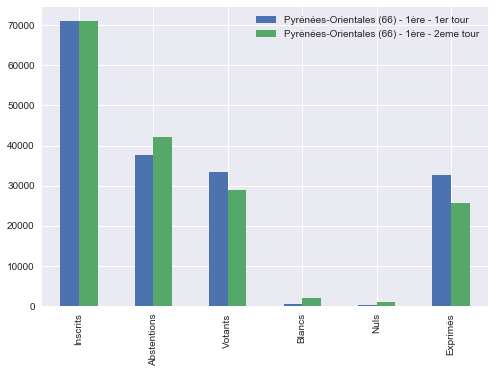

In [18]:
pd.concat((stats_turn1, stats_turn2), axis=1).plot.bar()

Comme on peut le voir sur le graphique, les électeurs se sont démobilisés pour le deuxième tour. Au lieu de regarder deux chiffres, on peut également s'intéresser à la différence du nombre de voix pour chaque catégorie.

In [19]:
pd.DataFrame(data=stats_turn2.values - stats_turn1.values, index=stats_turn1.index, columns=all_stats[0][0].columns)

,Pyrénées-Orientales (66) - 1ère
Inscrits,2
Abstentions,4516
Votants,-4514
Blancs,1640
Nuls,727
Exprimés,-6881


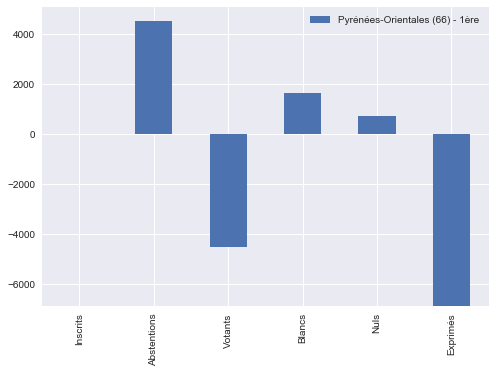

In [20]:
pd.DataFrame(data=stats_turn2.values - stats_turn1.values, index=stats_turn1.index, columns=all_stats[0][0].columns).plot.bar()

Représentons maintenant les différences en terme d'abstention pour toutes les circonscriptions ayant votées deux fois.

In [21]:
deltas = []
for stats in all_stats:
    stats_turn1, stats_turn2 = stats
    delta = pd.DataFrame(data=stats_turn2.values - stats_turn1.values, index=stats_turn1.index, columns=stats_turn1.columns)
    deltas.append(delta.transpose()['Abstentions'])
abstention = pd.concat(deltas)

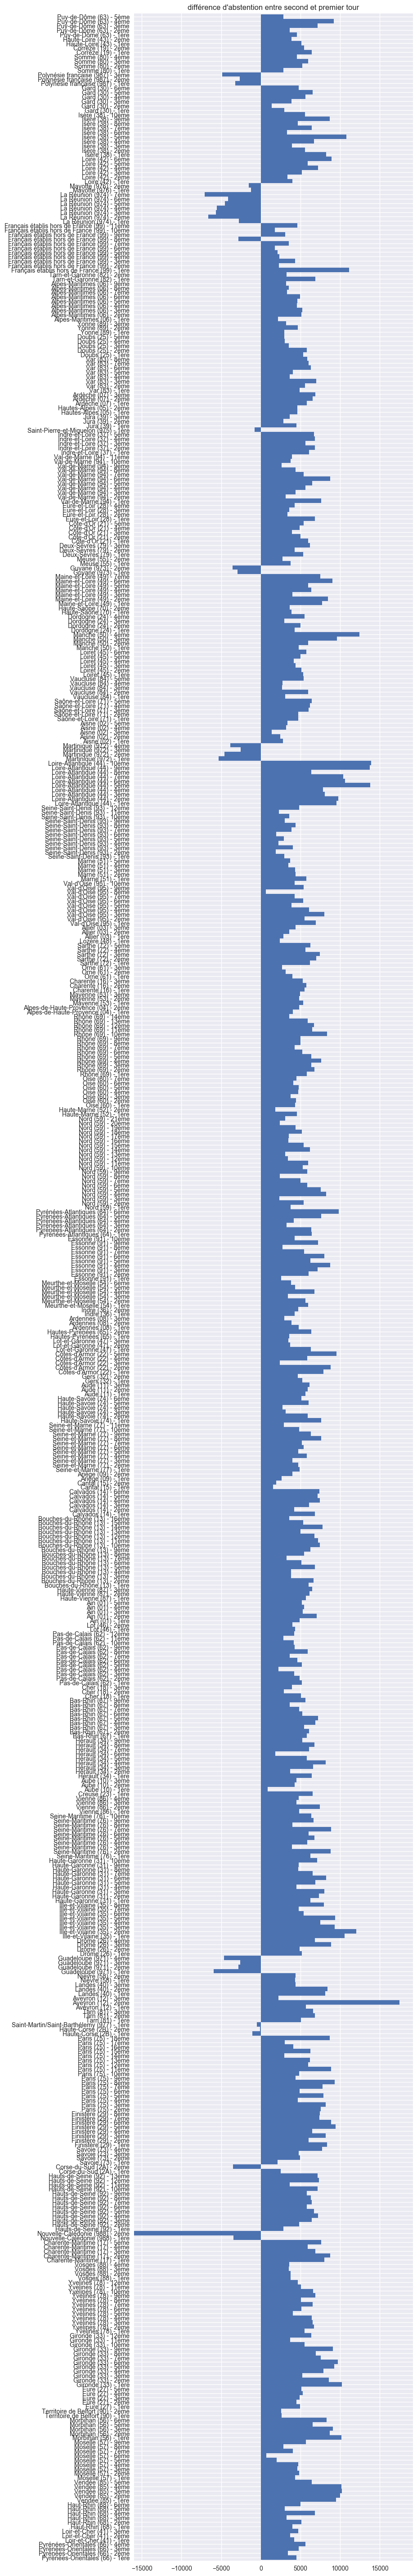

In [22]:
fig, ax = plt.subplots(figsize=(8, 75), dpi=100)
abstention.plot.barh(stacked=True, ax=ax, width=1.0)
plt.title("différence d'abstention entre second et premier tour")

Au total, la somme de l'abstention supplémentaire est de 2,8 millions d'inscrits.

In [23]:
abstention.sum()

2848180

On peut également tracer l'histogramme des différences d'abstentions.

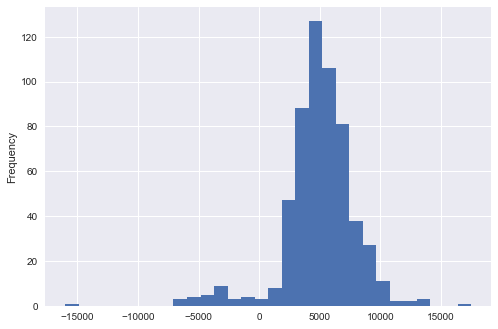

In [24]:
abstention.plot.hist(bins=30)

En moyenne, on a donc 5000 électeurs de plus par circonscription qui ont décidé de ne pas aller aux urnes pour le second tour.

## Histogrammes pour les votes blancs, nuls et les inscrits

En complément, on peut également regarder les variations des votes blancs, des nuls et du nombre d'inscrit entre les deux tours.

In [25]:
deltas = []
for stats in all_stats:
    stats_turn1, stats_turn2 = stats
    delta = pd.DataFrame(data=stats_turn2.values - stats_turn1.values, index=stats_turn1.index, columns=stats_turn1.columns)
    deltas.append(delta.transpose())
delta = pd.concat(deltas)

/Users/kappamaki/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114fd1c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114cfabe0>]], dtype=object)

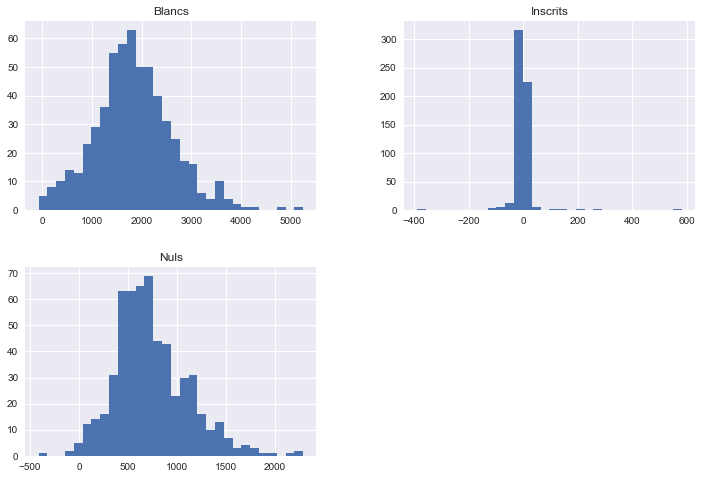

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
delta[['Blancs', 'Nuls', 'Inscrits']].hist(bins=30, ax=ax)

## Les gagnants du premier tour gagnent-ils au second ? 

On peut également poser une autre question : un candidat en tête des votes au premier tour gagne-t-il aussi au deuxième tour ? Essayons de répondre à cette question avec des graphiques.

On va utiliser les tableaux des candidats pour les circonscriptions à deux tours.

In [27]:
all_candidates = []
for link in circo_links:
    data = extract_circo_data(link)
    if len(data) == 5:
        circo_name, candidates_turn1, stats_turn1, candidates_turn2, stats_turn2 = data
        all_candidates.append((candidates_turn1, candidates_turn2))

Prenons un exemple :

In [34]:
candidates_turn1, candidates_turn2 = all_candidates[124]

In [37]:
def make_comparison_df(candidates_turn1, candidates_turn2):
    "Concatenates second and first round data."
    first_part = pd.to_numeric(candidates_turn1[~candidates_turn1['Elu(e)'].str.contains('Non')]['voix']).to_frame().transpose()
    first_part.index = [row + ' 1er tour' for row in first_part.index]  
    second_part = pd.to_numeric(candidates_turn2['voix']).to_frame().transpose()
    second_part.index = [row + ' 2eme tour' for row in second_part.index]  
    return pd.concat((first_part, second_part))

In [38]:
make_comparison_df(candidates_turn1, candidates_turn2)

,M. Stéphane MAZARS,M. Yves CENSI
voix 1er tour,19962,9923
voix 2eme tour,23217,11763


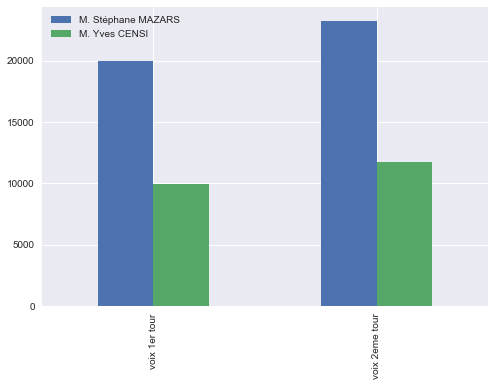

In [39]:
make_comparison_df(candidates_turn1, candidates_turn2).plot.bar()

Dans ce cas là, le candidat en tête au premier tour l'a emporté au deuxième. Faisons des statistiques pour toutes les circonscriptions.

In [40]:
won_first_and_second = []
for candidates_turn1, candidates_turn2 in all_candidates:
    df = make_comparison_df(candidates_turn1, candidates_turn2)
    if df.iloc[0].argmax() == df.iloc[1].argmax():
        won_first_and_second += [True]
    else:
        won_first_and_second += [False]

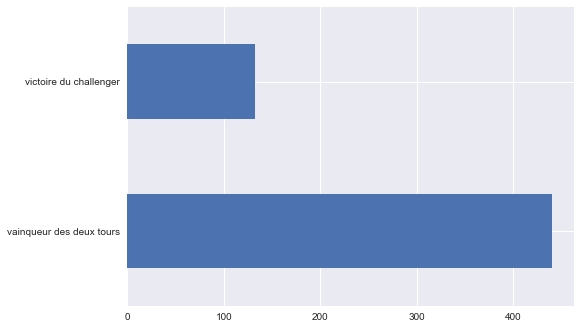

In [41]:
df_won_first_and_second = pd.Series(won_first_and_second).value_counts()
df_won_first_and_second.index = ['vainqueur des deux tours', 'victoire du challenger']
df_won_first_and_second.plot.barh()

In [42]:
df_won_first_and_second.to_frame(name='comptage')

,comptage
vainqueur des deux tours,441
victoire du challenger,132


Comme on peut le voir, quatre fois sur cinq c'est le candidat vainqueur du premier tour qui l'emporte au second. Mais est-ce que ceci est vrai pour tous les partis de la même manière ? Voyons voir ça de plus près. 

In [43]:
def make_comparison_party_df(candidates_turn1, candidates_turn2):
    "Concatenates second and first round data."
    first_part = pd.to_numeric(candidates_turn1[~candidates_turn1['Elu(e)'].str.contains('Non')]['voix']).to_frame().transpose()
    first_part.index = [row + ' 1er tour' for row in first_part.index]  
    second_part = pd.to_numeric(candidates_turn2['voix']).to_frame().transpose()
    second_part.index = [row + ' 2eme tour' for row in second_part.index]  
    third_part = candidates_turn1[~candidates_turn1['Elu(e)'].str.contains('Non')]['nuance'].to_frame().transpose()
    return pd.concat((first_part, second_part, third_part))

In [44]:
df = make_comparison_party_df(candidates_turn1, candidates_turn2)
df

,M. André CHASSAIGNE,M. Sébastien GARDETTE
voix 1er tour,18444,15491
voix 2eme tour,30620,17561
nuance,COM,REM


In [45]:
all_circos = []
for link in circo_links:
    data = extract_circo_data(link)
    if len(data) == 5:
        all_circos.append(data[0]) 

In [46]:
won_first_and_second = []
for (candidates_turn1, candidates_turn2), name in zip(all_candidates, all_circos):
    df = make_comparison_party_df(candidates_turn1, candidates_turn2)
    delta_voices_first_round = df[df.iloc[0].argmax()].values[0] - df[df.iloc[0].argmin()].values[0]
    party = df[df.iloc[0].argmax()]['nuance']
    if df.iloc[0].argmax() == df.iloc[1].argmax():
        won_first_and_second += [(party, True, delta_voices_first_round)]
    else:
        won_first_and_second += [(party, False, delta_voices_first_round)]

In [47]:
df_won_first_and_second = pd.DataFrame(won_first_and_second, columns=['Vainqueur premier tour', 'Vainqueur deux fois', 'Ecart premier tour'], index=all_circos)

In [48]:
df_won_first_and_second.head()

,Vainqueur premier tour,Vainqueur deux fois,Ecart premier tour
Pyrénées-Orientales (66) - 1ère,REM,True,3748
Pyrénées-Orientales (66) - 2ème,FN,True,781
Pyrénées-Orientales (66) - 3ème,REM,True,1360
Pyrénées-Orientales (66) - 4ème,REM,True,4285
Loir-et-Cher (41) - 1ère,MDM,True,7955


In [49]:
df_results = pd.concat([df_won_first_and_second.groupby('Vainqueur premier tour').sum()['Vainqueur deux fois'].to_frame(name='vainqueur au 2eme tour'),
           df_won_first_and_second.groupby('Vainqueur premier tour').count()['Vainqueur deux fois'].to_frame(name='en tête au 1er tour')], axis=1)

Ce qui donne : 

In [50]:
df_results

,vainqueur au 2eme tour,en tête au 1er tour
Vainqueur premier tour,,
COM,5.0,5
DIV,1.0,3
DVD,4.0,6
DVG,8.0,9
ECO,1.0,1
FI,3.0,3
FN,8.0,20
LR,45.0,48
MDM,42.0,52


Ou graphiquement :

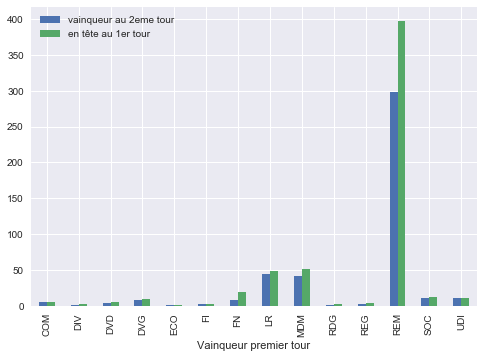

In [51]:
df_results.plot.bar()

Ou encore :

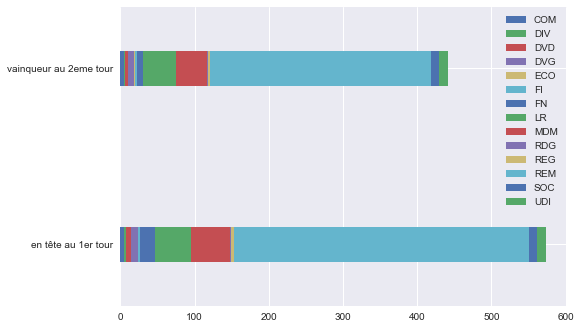

In [52]:
df_results[['vainqueur au 2eme tour', 'en tête au 1er tour']].transpose().iloc[::-1].plot.barh(stacked=True, width=0.2)
plt.legend(loc='upper right')

On peut en déduire le taux de succès parmi tous les partis :

In [53]:
df_results['taux de succès au second tour si en tête'] = df_results['vainqueur au 2eme tour'] / df_results['en tête au 1er tour']

In [54]:
df_results.sort_values(by='taux de succès au second tour si en tête')

,vainqueur au 2eme tour,en tête au 1er tour,taux de succès au second tour si en tête
Vainqueur premier tour,,,
DIV,1.0,3,0.333333
FN,8.0,20,0.400000
RDG,1.0,2,0.500000
DVD,4.0,6,0.666667
REG,3.0,4,0.750000
REM,298.0,397,0.750630
MDM,42.0,52,0.807692
DVG,8.0,9,0.888889
SOC,11.0,12,0.916667


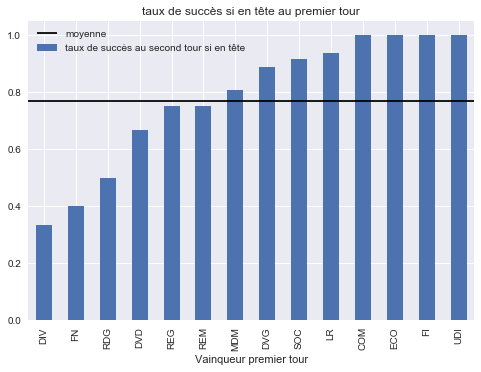

In [55]:
df_results.sort_values(by='taux de succès au second tour si en tête')['taux de succès au second tour si en tête'].plot.bar()
plt.title('taux de succès si en tête au premier tour')
plt.hlines(441/573, -1, 14, label='moyenne')
plt.legend()

L'une des choses intéressantes qui ressort de ce graphique est que le FN est beaucoup moins performant que les autres partis quand il est en tête au premier tour.

Nous avons maintenant conclu cette partie statistique descriptive. Passons à la modélisation du second tour.

# Modélisation des reports de vote 

Etant ignorant en économétrie électorale, je propose ici une approche comparative entre trois modèles de report de vote. Nous ferons l'hypothèse que les électeurs qui ont voté pour un candidat qui reste présent au second tour voteront à nouveau pour lui. De plus, nous feront également l'hypothèse que l'abstention reste identique au premier comme au deuxième tour (ce qui est faux, comme on l'a bien vu, mais plus facile à implémenter).

- le premier modèle propose qu'un électeur au premier tour d'un candidat qui n'est pas en ballotage choisit l'un des candidats restants au hasard
- le deuxième modèle propose qu'un électeur au premier tour d'un candidat qui n'est pas en ballotage choisit l'un des candidats restants en proportion de ses voix au premier tour (ce qui donne un avantage au candidat en tête au premier tour)
- le troisième modèle propose qu'un électeur au premier tour d'un candidat qui n'est pas en ballotage choisit l'un des candidats restants vis à vis d'une distance politique entre son candidat du premier tour et les candidats en ballotage

## Premier modèle : report hasardeux 

Pour définir ce premier modèle nous avons besoin de faire deux choses : réunir les voix disponibles et les assigner au hasard à l'un des deux candidats. Je reprends là encore les idées d'[il y a deux semaines](http://flothesof.github.io/resultats-legislatives-2017-premier-tour.html).

La somme de $n$ variables aléatoires de Bernoulli suit une loi binomiale, qui existe dans le package `scipy.stats`. Nous allons utiliser celui-ci pour faire les tirages.

In [56]:
from scipy import stats

In [57]:
def predict_winner_random(candidates_turn1, size=1):
    "Simulates who will win a given circonscription using data from first round. Random model."
    # winners
    mask = (candidates_turn1['Elu(e)'] == 'Ballotage*')
    voices = pd.to_numeric(candidates_turn1.voix[mask]).values
    nuances = candidates_turn1.nuance[mask].values
    # free voices
    free_voices = pd.to_numeric(candidates_turn1.voix[~mask]).sum()
    simulated_reports_winner = stats.binom(free_voices, 0.5).rvs(size=size)
    simulated_results = np.zeros((voices.size, size))
    simulated_results[0, :] += voices[0]
    simulated_results[1, :] += voices[1]
    simulated_results[0, :] += simulated_reports_winner
    simulated_results[1, :] += (free_voices - simulated_reports_winner)
    return nuances[simulated_results.argmax(axis=0)]

In [58]:
predict_winner_random(candidates_turn1, size=100)

array(['COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM'], dtype=object)

In [59]:
candidates_turn1

,nuance,voix,% Inscrits,% Exprimés,Elu(e)
M. André CHASSAIGNE,COM,18444,18.07,34.85,Ballotage*
M. Sébastien GARDETTE,REM,15491,15.18,29.27,Ballotage*
M. Jérôme JAYET,FN,5267,5.16,9.95,Non
Mme Myriam FOUGÈRE,LR,5125,5.02,9.68,Non
Mme Sara PERRET,FI,3612,3.54,6.82,Non
M. Gérard BETENFELD,SOC,1704,1.67,3.22,Non
M. Jérémy PRÉVOST,DLF,845,0.83,1.60,Non
Mme Claire LESPAGNOL,ECO,716,0.70,1.35,Non
M. Mikaël MONTAGNON,ECO,669,0.66,1.26,Non
Mme Florence DINOUARD,UDI,495,0.49,0.94,Non


Comme on le voit, le modèle prévoit sur cette circonscription la victoire du candidat communiste, en tête au premier tour. 

On peut appliquer cette méthodologie à l'ensemble des circonscriptions pour obtenir des assemblées nationales simulées.

In [61]:
simulation_data = []
size = 1000
for candidates_turn1, candidates_turn2 in all_candidates:
    simulation_data.append(predict_winner_random(candidates_turn1, size=size))    

Il faut également rajouter à ces données les vainqueurs connus dès le premier tour pour ne pas fausser les résultats.

In [62]:
already_elected = []
for link in circo_links:
    data = extract_circo_data(link)
    if len(data) == 3:
        circo_name, candidates_turn1, stats_turn1 = data
        already_elected.append(candidates_turn1.iloc[0]['nuance'])

In [63]:
already_elected

['DVG', 'REM', 'REM', 'UDI']

In [64]:
for elected in already_elected:
    simulation_data.append([elected] * size)

On construit maintenant les assemblées virtuelles.

In [65]:
parliaments = pd.DataFrame(simulation_data).transpose()

In [66]:
parliaments.head()

,0,1,2,3,4,5,6,7,8,9,...,567,568,569,570,571,572,573,574,575,576
0,REM,FN,REM,REM,MDM,REM,UDI,LR,REM,REM,...,LR,REM,REM,MDM,MDM,COM,DVG,REM,REM,UDI
1,REM,FN,REM,REM,MDM,LR,UDI,LR,REM,REM,...,LR,REM,REM,MDM,MDM,COM,DVG,REM,REM,UDI
2,REM,FN,REM,REM,MDM,LR,UDI,LR,REM,REM,...,LR,REM,REM,MDM,MDM,COM,DVG,REM,REM,UDI
3,REM,FN,REM,REM,MDM,LR,UDI,LR,REM,REM,...,LR,REM,REM,MDM,MDM,COM,DVG,REM,REM,UDI
4,REM,FN,REM,REM,MDM,REM,UDI,LR,REM,REM,...,LR,REM,REM,MDM,MDM,COM,DVG,REM,REM,UDI


In [67]:
parliament_counts = pd.concat([series.value_counts() for ind, series in parliaments.iterrows()], axis=1).fillna(value=0)

In [68]:
parliament_stats_model1 = parliament_counts.transpose().describe().transpose().sort_values(by='mean')[['min', '25%', '50%', '75%', 'max']].transpose().astype(int)

Voilà donc les résultats pour ce modèle.

In [69]:
parliament_stats_model1

,ECO,RDG,DIV,FI,REG,COM,DVD,DVG,SOC,UDI,FN,LR,MDM,REM
min,1,1,1,3,4,4,5,9,11,11,18,45,52,395
25%,1,2,2,3,4,5,6,9,11,12,19,48,52,398
50%,1,2,3,3,4,5,6,10,12,12,20,49,52,399
75%,1,3,3,3,4,6,6,10,12,12,20,49,53,400
max,1,3,4,3,4,6,6,10,12,13,22,52,54,403


In [71]:
import seaborn as sns

/Users/kappamaki/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


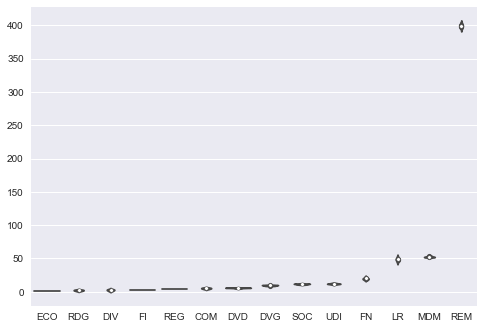

In [72]:
sns.violinplot(parliament_stats_model1)

On constate que ce premier modèle n'apporte finalement pas grand chose : les gagnants du premier tour maintiennent leur avance car les électeurs restants se répartissent entre eux.

## Deuxième modèle : avantage au vainqueur du premier tour

On reprend la fonction de simulation précédente. Il suffit de changer les probabilités de la loi binomiale pour simuler ce modèle.

In [73]:
def predict_winner_follow(candidates_turn1, size=1):
    "Simulates who will win a given circonscription using data from first round. Winner following model."
    # winners
    mask = (candidates_turn1['Elu(e)'] == 'Ballotage*')
    voices = pd.to_numeric(candidates_turn1.voix[mask]).values
    nuances = candidates_turn1.nuance[mask].values
    # free voices
    free_voices = pd.to_numeric(candidates_turn1.voix[~mask]).sum()
    winner_index = pd.to_numeric(candidates_turn1[mask]['voix']).argmax()
    assert winner_index == candidates_turn1.index[0]
    simulated_reports_winner = stats.binom(free_voices, voices[0]/voices.sum()).rvs(size=size)
    simulated_results = np.zeros((voices.size, size))
    simulated_results[0, :] += voices[0]
    simulated_results[1, :] += voices[1]
    simulated_results[0, :] += simulated_reports_winner
    simulated_results[1, :] += (free_voices - simulated_reports_winner)
    return nuances[simulated_results.argmax(axis=0)]

In [74]:
candidates_turn1, candidates_turn2 = all_candidates[0]

In [75]:
predict_winner_follow(candidates_turn1, size=10)

array(['REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM', 'REM'], dtype=object)

On peut appliquer cette méthodologie à l'ensemble des circonscriptions pour obtenir des assemblées nationales simulées.

In [76]:
simulation_data = []
size = 1000
for candidates_turn1, candidates_turn2 in all_candidates:
    simulation_data.append(predict_winner_follow(candidates_turn1, size=size))    

Il faut également rajouter à ces données les vainqueurs connus dès le premier tour pour ne pas fausser les résultats.

In [77]:
for elected in already_elected:
    simulation_data.append([elected] * size)

On construit maintenant les assemblées virtuelles.

In [78]:
parliaments = pd.DataFrame(simulation_data).transpose()

In [79]:
parliaments.head()

,0,1,2,3,4,5,6,7,8,9,...,567,568,569,570,571,572,573,574,575,576
0,REM,FN,REM,REM,MDM,LR,UDI,LR,REM,REM,...,LR,REM,REM,MDM,MDM,COM,DVG,REM,REM,UDI
1,REM,FN,REM,REM,MDM,LR,UDI,LR,REM,REM,...,LR,REM,REM,MDM,MDM,COM,DVG,REM,REM,UDI
2,REM,FN,REM,REM,MDM,LR,UDI,LR,REM,REM,...,LR,REM,REM,MDM,MDM,COM,DVG,REM,REM,UDI
3,REM,FN,REM,REM,MDM,LR,UDI,LR,REM,REM,...,LR,REM,REM,MDM,MDM,COM,DVG,REM,REM,UDI
4,REM,FN,REM,REM,MDM,LR,UDI,LR,REM,REM,...,LR,REM,REM,MDM,MDM,COM,DVG,REM,REM,UDI


In [80]:
parliament_counts = pd.concat([series.value_counts() for ind, series in parliaments.iterrows()], axis=1).fillna(value=0)

In [81]:
parliament_stats_model2 = parliament_counts.transpose().describe().transpose().sort_values(by='mean')[['min', '25%', '50%', '75%', 'max']].transpose().astype(int)

Voilà donc les résultats pour ce modèle.

In [82]:
parliament_stats_model2

,ECO,DIV,RDG,FI,REG,COM,DVD,DVG,SOC,UDI,FN,LR,MDM,REM
min,1,2,1,3,4,5,6,9,11,11,19,47,52,394
25%,1,2,2,3,4,5,6,9,11,12,20,49,52,397
50%,1,2,3,3,4,5,6,10,12,12,20,50,52,398
75%,1,3,3,3,4,6,6,10,12,12,20,50,53,399
max,1,3,3,3,4,6,6,10,12,12,22,52,53,401


/Users/kappamaki/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


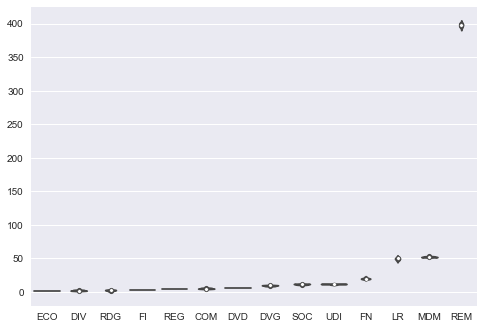

In [83]:
sns.violinplot(parliament_stats_model2)

Comme on peut le voir dans le tableau ci-dessus, le modèle de report des voix libres vis à vis du vainqueur n'introduit en fait quasiment ancune variabilité. Comme le premier modèle. Intuitivement, ce n'est pas étonnant : c'est comme si on gardait les vainqueurs du premier tour et c'est tout.

## Troisième modèle : une matrice des distances 

Finalement, une idée plus intéressante concernant le report est celle d'une proximité idéologique vers le parti sur lequel l'électeur va se reporter vis à vis du parti qu'il a choisi au premier tour. Différentes manières de représenter cette distance idéologique existent. 
Par exemple :
![carte](http://www.gaucheliberale.org/public/ppf-11-11.jpg)

Je m'inspire ici de deux articles ([ici](http://www.agoravox.fr/tribune-libre/article/partis-politiques-en-europe-gauche-21200) et [ici](http://www.gaucheliberale.org/post/2011/11/04/Carte-2D-du-Paysage-Politique-Français-%28PPF%29-mise-à-jour-novembre-2011), dont est tiré la carte ci-dessus) pour positionner les partis seulement deux coordonnées :

- économique (0 : conservateur, 1 : libéral)
- social (0 : conservateur, 1 : libéral)

Les partis auxquels il faut assigner un positionnement sont les suivants :

In [84]:
all_nuances = pd.concat([extract_circo_data(link)[1] for link in circo_links])['nuance'].unique()
all_nuances

array(['DVG', 'LR', 'REM', 'FN', 'FI', 'COM', 'REG', 'DLF', 'DIV', 'EXG',
       'MDM', 'SOC', 'ECO', 'DVD', 'UDI', 'RDG', 'EXD'], dtype=object)

In [85]:
classifications = {'DVG': (1, 1),
                   'LR':  (1, 0),
                   'FI':  (0, 1),
                   'FN':  (0, 0),
                   'DVD': (1, 0),
                   'COM': (0, 1),
                   'DIV': (0.5, 0.5),
                   'DLF': (1, 0),
                   'EXG': (0, 1),
                   'ECO': (0.5, 1),
                   'MDM': (0.5, 0.5),
                   'REM': (0.5, 0.5),
                   'SOC': (1, 1),
                   'UDI': (0.5, 0),
                   'EXD': (0, 0),
                   'REG': (0, 0),
                   'RDG': (0, 1)}

In [86]:
classifications_df = pd.DataFrame(classifications, index=['économique', 'social']).transpose()
classifications_df

,économique,social
COM,0.0,1.0
DIV,0.5,0.5
DLF,1.0,0.0
DVD,1.0,0.0
DVG,1.0,1.0
ECO,0.5,1.0
EXD,0.0,0.0
EXG,0.0,1.0
FI,0.0,1.0
FN,0.0,0.0


In [87]:
classifications_df += np.random.uniform(low=-0.1, high=0.1, size=classifications_df.values.shape)

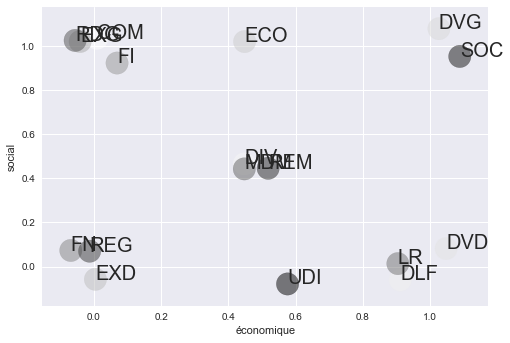

In [88]:
classifications_df.plot.scatter(x='économique', y='social', 
                                s=500, c=pd.Categorical(classifications_df.index).codes,
                               alpha=0.5)
for ind, row in classifications_df.iterrows():
    plt.annotate(ind, (row['économique'], row['social']), fontsize=20)

A partir de cette carte, on peut construire une matrice des distances entre partis.

In [89]:
distances = {}
for nuance1 in classifications_df.index:
    for nuance2 in all_nuances:
        distances[nuance1 + '-' + nuance2] = np.sqrt(((classifications_df.loc[nuance1].values - classifications_df.loc[nuance2].values)**2).sum())

Enfin, on peut écrire une fonction qui va assigner les voix aux différents partis en fonction de la distance aux candidats possibles.

In [90]:
def predict_winner_distance(candidates_turn1, size=1):
    "Simulates who will win a given circonscription using data from first round. Political distance model."
    # winners
    mask = (candidates_turn1['Elu(e)'] == 'Ballotage*')
    voices = pd.to_numeric(candidates_turn1.voix[mask]).values
    nuances = candidates_turn1.nuance[mask].values
    simulated_results = np.zeros((voices.size, size))
    simulated_results[0, :] += voices[0]
    simulated_results[1, :] += voices[1]
    # free voices
    free_voices = candidates_turn1[~mask]
    for ind, row in free_voices.iterrows():
        nuance = row.loc['nuance']
        current_distances = [np.exp(distances[nuance + '-' + nuance2]) for nuance2 in nuances]
        simulated_reports_winner = stats.binom(int(row['voix']), current_distances[0]/sum(current_distances)).rvs(size=size)
        simulated_results[0, :] += simulated_reports_winner
        simulated_results[1, :] += (int(row['voix']) - simulated_reports_winner)
    return nuances[simulated_results.argmax(axis=0)]

In [91]:
predict_winner_distance(candidates_turn1, size=100)

array(['COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM',
       'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM', 'COM'], dtype=object)

On peut appliquer cette méthodologie à l'ensemble des circonscriptions pour obtenir des assemblées nationales simulées.

In [92]:
simulation_data = []
size = 1000
for candidates_turn1, candidates_turn2 in all_candidates:
    simulation_data.append(predict_winner_distance(candidates_turn1, size=size))    

Il faut également rajouter à ces données les vainqueurs connus dès le premier tour pour ne pas fausser les résultats.

In [93]:
for elected in already_elected:
    simulation_data.append([elected] * size)

On construit maintenant les assemblées virtuelles.

In [94]:
parliaments = pd.DataFrame(simulation_data).transpose()

In [95]:
parliaments.head()

,0,1,2,3,4,5,6,7,8,9,...,567,568,569,570,571,572,573,574,575,576
0,REM,FN,FN,REM,MDM,LR,UDI,LR,REM,LR,...,LR,REM,SOC,MDM,MDM,COM,DVG,REM,REM,UDI
1,REM,FN,FN,REM,MDM,LR,UDI,LR,REM,LR,...,LR,REM,SOC,MDM,MDM,COM,DVG,REM,REM,UDI
2,REM,FN,FN,REM,MDM,LR,UDI,LR,REM,LR,...,LR,REM,SOC,MDM,MDM,COM,DVG,REM,REM,UDI
3,REM,FN,FN,REM,MDM,LR,UDI,LR,REM,LR,...,LR,REM,SOC,MDM,MDM,COM,DVG,REM,REM,UDI
4,REM,FN,FN,REM,MDM,LR,UDI,LR,REM,LR,...,LR,REM,SOC,MDM,MDM,COM,DVG,REM,REM,UDI


In [96]:
parliament_counts = pd.concat([series.value_counts() for ind, series in parliaments.iterrows()], axis=1).fillna(value=0)

In [97]:
parliament_stats_model3 = parliament_counts.transpose().describe().transpose().sort_values(by='mean')[['min', '25%', '50%', '75%', 'max']].transpose().astype(int)

Voilà donc les résultats pour ce modèle.

In [98]:
parliament_stats_model3

,DIV,DLF,ECO,RDG,REG,DVD,FI,COM,DVG,UDI,SOC,MDM,FN,LR,REM
min,0,0,1,2,5,5,4,7,11,13,26,39,50,90,305
25%,0,1,1,2,5,5,5,7,11,13,27,40,52,94,309
50%,1,1,1,2,5,5,5,7,11,13,28,40,53,95,310
75%,1,1,1,2,5,6,6,7,11,13,28,40,53,96,311
max,1,1,1,2,5,6,6,8,11,14,29,42,55,99,316


/Users/kappamaki/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


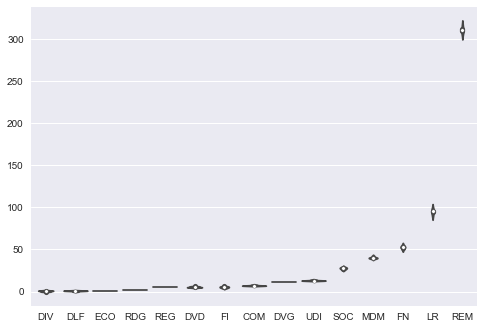

In [99]:
sns.violinplot(parliament_stats_model3)

Cette fois-ci les résultats générés par le modèle sont un peu plus variés que dans les deux cas précédents. En particulier il ne donne pas une aussi grande priorité aux vainqueurs du premier tour.

## Comparaison des modèles aux résultats réels

Pour finir, comparons les trois modèles aux vrais résultats des élections, disponibles [ici](http://elections.interieur.gouv.fr/legislatives-2017/FE.html), mais que nous allons recalculer à partir des données déjà extraites.

In [100]:
true_results = pd.Series([candidates_turn2.iloc[0]['nuance'] for candidates_turn1, candidates_turn2 in all_candidates] + already_elected).value_counts()

On peut construire un tableau avec la prédiction moyenne de chaque modèle (vu que la répartition est assez uniforme pour chaque distribution de modèle).

In [101]:
model_vs_reality = pd.concat([true_results.to_frame(name='députés élus 2017'), 
           parliament_stats_model1.transpose()['50%'].to_frame(name='modèle 1'),
           parliament_stats_model2.transpose()['50%'].to_frame(name='modèle 2'),
           parliament_stats_model3.transpose()['50%'].to_frame(name='modèle 3')], axis=1).fillna(0).sort_values(by='députés élus 2017', ascending=False)
model_vs_reality

,députés élus 2017,modèle 1,modèle 2,modèle 3
REM,308,399.0,398.0,310.0
LR,112,49.0,50.0,95.0
MDM,42,52.0,52.0,40.0
SOC,30,12.0,12.0,28.0
UDI,18,12.0,12.0,13.0
FI,17,3.0,3.0,5.0
DVG,12,10.0,10.0,11.0
COM,10,5.0,5.0,7.0
FN,8,20.0,20.0,53.0
DVD,6,6.0,6.0,5.0


Graphiquement, cela donne :

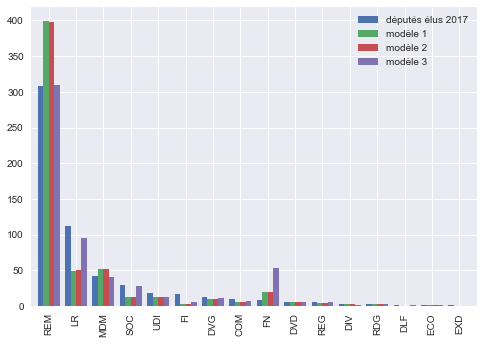

In [102]:
model_vs_reality.plot.bar(width=0.8)

On peut calculer des erreurs moyennes par modèles.

In [103]:
for col in ['modèle 1', 'modèle 2', 'modèle 3']:
    model_vs_reality['erreur ' + col] = model_vs_reality[col] - model_vs_reality['députés élus 2017']

In [104]:
model_vs_reality[model_vs_reality.columns[model_vs_reality.columns.str.contains('erreur')]]

,erreur modèle 1,erreur modèle 2,erreur modèle 3
REM,91.0,90.0,2.0
LR,-63.0,-62.0,-17.0
MDM,10.0,10.0,-2.0
SOC,-18.0,-18.0,-2.0
UDI,-6.0,-6.0,-5.0
FI,-14.0,-14.0,-12.0
DVG,-2.0,-2.0,-1.0
COM,-5.0,-5.0,-3.0
FN,12.0,12.0,45.0
DVD,0.0,0.0,-1.0


In [105]:
model_vs_reality[model_vs_reality.columns[model_vs_reality.columns.str.contains('erreur')]].abs().mean(axis=0).to_frame(name='erreur absolue moyenne')

,erreur absolue moyenne
erreur modèle 1,14.0625
erreur modèle 2,13.9375
erreur modèle 3,5.8750


On constate que les modèles 1 et 2 commettent une erreur absolue moyenne plus importante que le modèle 3. Si on regarde plus précisément le modèle 3, on voit qu'il se trompe principalement sur la prédiction du vote FN, d'environ 50 sièges et également de la France Insoumise, pour laquelle il ne prédit quasiment aucun siège :

In [107]:
model_vs_reality['erreur modèle 3'].sort_values(ascending=False).to_frame(name='erreurs en siège')

,erreurs en siège
FN,45.0
REM,2.0
ECO,0.0
DLF,0.0
REG,0.0
EXD,-1.0
RDG,-1.0
DVD,-1.0
DVG,-1.0
DIV,-2.0


Je pense que l'on peut ici répéter ce que l'on a constaté dans la première partie lors de l'analyse des vainqueurs du premier tour : même si le FN est passé dans de nombreuses circonscriptions au premier tour, les électeurs se sont probablement mobilisés contre au second tour. Je suppose que l'effet inverse s'est produit chez les électeurs de la France Insoumise, qui se sont peut être plus mobilisés au second tour pour "sauver" des candidats.

# Conclusions 

Dans ce billet, nous sommes partis des données disponibles sur internet par le ministère de l'intérieur pour proposer une visualisation des résultats des législatives ainsi qu'une analyse basée sur des modèles de reports de votes assez simples. Je ne prétend bien évidemment pas y connaître quoi que ce soit en analyse ou modélisation politique mais il me semble que l'on peut garder en tête certaines choses : la forte abstention supplémentaire au second tour, les victoires de vainqueurs du premier tour au second, les différences entre partis (par exemple pour le FN). 

La partie modélisation m'a particulièrement intéressé. Cependant, le travail fait sur ce sujet est malheureusement très pauvre. D'après mes recherches, plusieurs équipes développent des modèles quantitatifs qui permettraient de commencer à parler de ce sujet, peut-être dans le futur : [ElectionScope](http://www.atlantico.fr/decryptage/vote-lrem-majoritaire-entre-interet-general-et-moindre-mal-3069376.html) ou encore les travaux de la start-up [Liegey Muller Pons](http://www.liegeymullerpons.fr/fr/partenariat-figaro-premier-tour-legislatives/). Les méthodes utilisées par Liegey Muller Pons semblent particulièrement intéressante dans la mesure où elles s'appuient sur un modèle quantitatif dit d'inférence écologique et qui permet de répondre au problème de la répartition du vote en fonction de descriptions quantitatives des circonscriptions (démographie, composition sociale). Pour plus d'information, il existe un article Wikipédia sur ce sujet [ici](https://fr.wikipedia.org/wiki/Inférence_écologique). 